In [1]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

df=pandas.read_csv('bench_fixed.csv')
factors=['scale', 'ver', 'net', 'index', 'opt']
df['scale'] = df['scale'].astype(str)
df['ver']=df['ver'].replace('p2d2.optimizer', 'pushed')
df['ver']=df['ver'].replace('p2d2.no_optimizer', 'orig')
df["vernet"] = df["ver"] +'_'+ df["net"]
df['scale_index']=df['scale']+'_'+df['index'].astype(str)
df_mean=df.drop('rep', axis=1).groupby(factors).mean().reset_index()
df_mean

,scale,ver,net,index,opt,wall_time,cpu_utilization,mem_usage,net_usage
0,1,orig,lan,False,excl,4.192642,0,0,0
1,1,orig,lan,False,incl,4.358035,0,0,0
2,1,orig,lan,True,excl,4.190277,0,0,0
3,1,orig,lan,True,incl,5.008413,0,0,0
4,1,orig,loc,False,excl,6.194205,0,0,0
5,1,orig,loc,False,incl,4.854226,0,0,0
6,1,orig,loc,True,excl,4.159123,0,0,0
7,1,orig,loc,True,incl,4.504964,0,0,0
8,1,orig,wan,False,excl,4.121369,0,0,0
9,1,orig,wan,False,incl,4.825797,0,0,0


In [2]:
#calculate profit
df_diff=df_mean.pivot(index=['scale','net','index','opt'],columns='ver', values=['wall_time','mem_usage', 'net_usage'])
for var in df_diff.columns.levels[0]:
    df_diff['diff_'+var]=df_diff[var]['orig']-df_diff[var]['pushed']
    

In [3]:
df_diff=df_diff.reset_index().drop(['wall_time','mem_usage','net_usage'], axis='columns', level=0)
df_diff=df_diff.droplevel(level=1, axis='columns')
df_diff.columns

Index(['scale', 'net', 'index', 'opt', 'diff_wall_time', 'diff_mem_usage',
       'diff_net_usage'],
      dtype='object')

In [4]:
#calculate overhead
df_diff['overhead'] = np.where(df_diff['opt'] == 'excl',
                                           df_diff['diff_wall_time'] * -1,
                                           df_diff['diff_wall_time'])


In [5]:
overhead = df_diff.groupby(['scale','net','index']).agg(
    {'overhead':np.sum})['overhead']

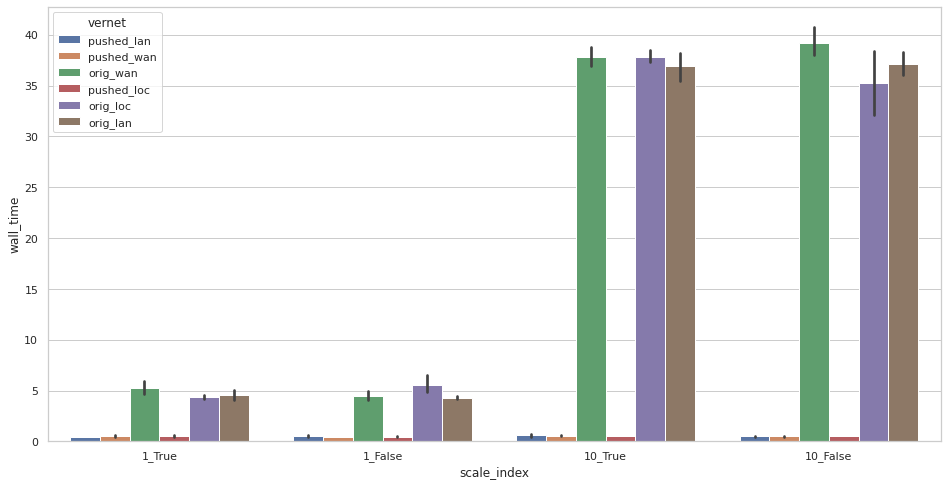

In [6]:
#hatch
#green=good
#storytelling (top->down)
f, ax = plt.subplots(figsize=(16, 8))
df=df.sort_values(by=['scale'])
lineplot=sns.barplot(data=df, x="scale_index", y="wall_time", hue='vernet')

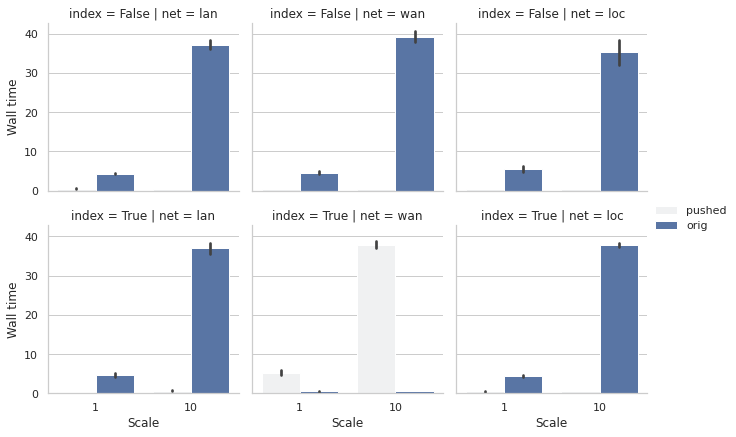

In [7]:
#logarithmic scale TODO
g = sns.FacetGrid(df, col="net",  row="index")
g.map_dataframe(sns.barplot, x="scale", y='wall_time', hue='ver')
g.set_axis_labels("Scale", "Wall time")
g.add_legend()

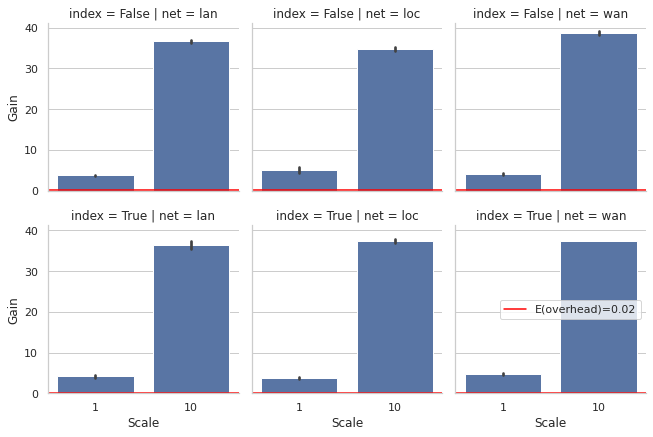

In [8]:
#speedup (different story)
g = sns.FacetGrid(df_diff, col="net",  row="index")
g.map_dataframe(sns.barplot, x="scale", y='diff_wall_time')
g.map(plt.axhline, y=overhead.mean(), color='red', label=f'E(overhead)={overhead.mean():.2f}')
g.set_axis_labels("Scale", "Gain")
plt.legend()

In [9]:
#add overhead on the x-axis
df_diff_overhead=df_diff[df_diff['scale']=='1'].copy()
df_diff_overhead['scale']='overhead'
df_diff_overhead['diff_wall_time']=overhead.mean()
df_overhead_x = pandas.concat([df_diff, df_diff_overhead])

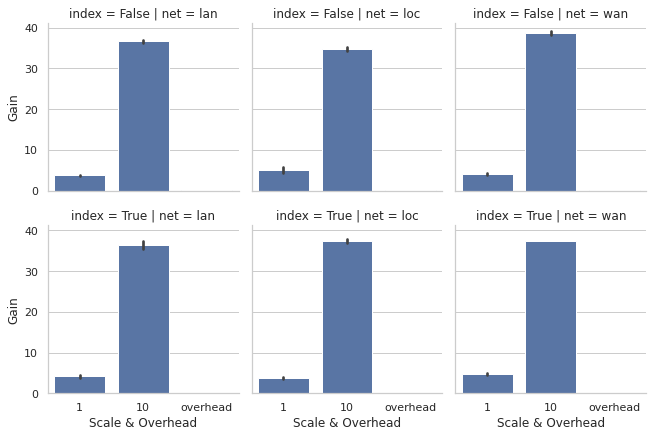

In [10]:
#df_overhead_x=df_overhead_x.sort_values(by=['diff_wall_time'])
g = sns.FacetGrid(df_overhead_x, col="net",  row="index")
g.map_dataframe(sns.barplot, x="scale", y='diff_wall_time')
g.set_axis_labels("Scale & Overhead", "Gain")

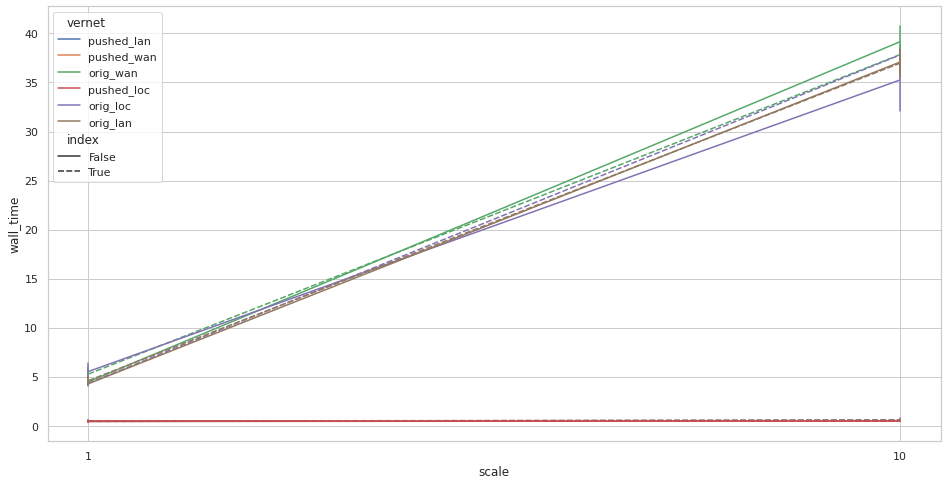

In [11]:
f, ax = plt.subplots(figsize=(16, 8))
lineplot=sns.lineplot(data=df, x="scale", y="wall_time", hue='vernet', style='index', err_style='bars')

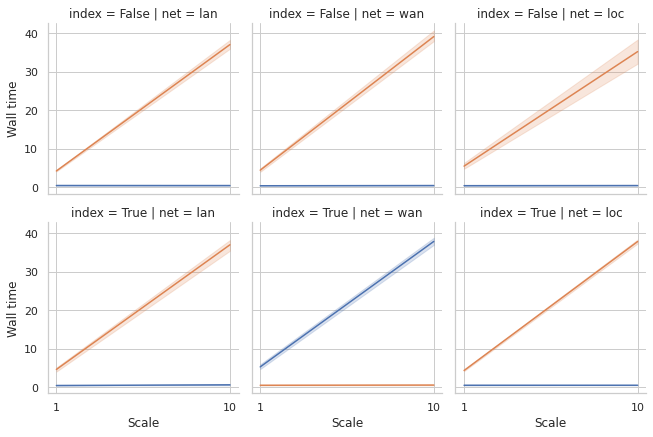

In [12]:
g = sns.FacetGrid(df, col="net",  row="index")
g.map_dataframe(sns.lineplot, x="scale", y='wall_time', hue='ver')
g.set_axis_labels("Scale", "Wall time")

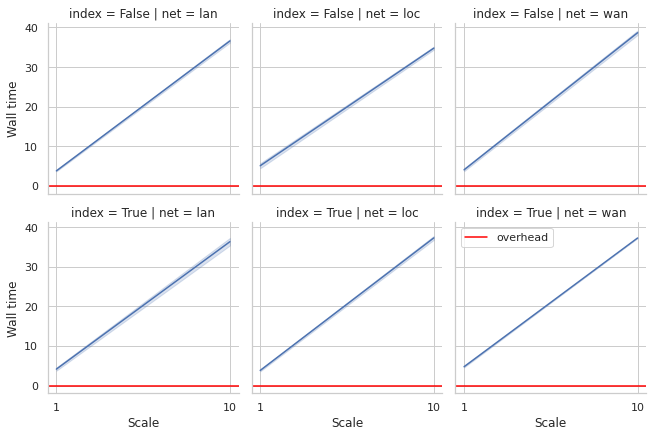

In [13]:
#better with the line
g = sns.FacetGrid(df_diff, col="net",  row="index")
g.map_dataframe(sns.lineplot, x="scale", y='diff_wall_time')
g.map(plt.axhline, y=overhead.mean(), color='red', label='overhead')
g.set_axis_labels("Scale", "Wall time")
plt.legend()

In [14]:

#fig = lineplot.get_figure()
#fig.savefig('all.png') 